<h2>Block Based Feature Learning</h2>

This illustrates how to use the PureSeq package to iterate through block of features copmuted from BAM files.

In [1]:
using PureSeq

In [2]:
function train_against_controls(targetFile, controlFiles, features; blockSize=100000, blockLimit=Inf, useReverseReads=false)
    
    # build our control feature maps
    readers = [FeatureMap(BamReader(controlFiles[i], useReverseReads, ReferenceContigs_hg38), features[i]) for i in 1:length(controlFiles)]
    
    # our target reader
    target = BamReader(targetFile, useReverseReads, ReferenceContigs_hg38)
    
    # we want to compute XtX and Xty block by block
    P = length(controlFiles) + 1
    XtX = zeros(P,P)
    Xty = zeros(P)
    printInterval = int(min(blockLimit, int(sum(ReferenceContigs_hg38.sizes)/blockSize))/10)
    
    # use denseblocks to iterate over blocks of the target and control data
    count = 0
    sse = 0.0
    sseTest = Float64[]
    for (target,control) in zip(denseblocks([target], blockSize), denseblocks(readers, blockSize, constantColumn=true, loop=true))
        count += 1
        if count > blockLimit break end
        
        # compute the betas for this data up to this point and get our test error on the next block
        betas = inv(XtX + 0.00001*eye(P))*Xty
        sse = sum((target - control*betas).^2)
        push!(sseTest, sse)

        # update our estimates
        XtX .+= control'control
        Xty .+= control'target
        
        if count % printInterval == 0
            println("Processed $(count*blockSize) positions...")
        end
    end
    betas = inv(XtX + 0.00001*eye(P))*Xty
    betas,sseTest
end

train_against_controls (generic function with 1 method)

In [3]:
root = "/scratch2/slund1/ENCSR000BQS_notebook"
targetId = "ENCFF000NYK"
controlIds35 = [
    "ENCFF000ODO", # designated control
    "ENCFF000ODV", # another GM12878 control (rep1)
    "ENCFF000ODZ", # another GM12878 control (rep2)
    "ENCFF000OEB", # another GM12878 control (rep3)
    "ENCFF000NGK",
    "ENCFF000NGM",
    "ENCFF000NGN",
    "ENCFF000QET",
    "ENCFF000QEU",
    "ENCFF000QFL",
    "ENCFF000QFS",
    "ENCFF000RCB",
    "ENCFF000RCC",
    "ENCFF000RCF",
    "ENCFF000RPT",
    "ENCFF000SAZ",
    "ENCFF000VPI",
    "ENCFF000VPK",
    "ENCFF000WIQ",
    "ENCFF000WIX",
    "ENCFF000WPT",
    "ENCFF000WPV",
    "ENCFF000XOO",
    "ENCFF000XRH",
    "ENCFF000XRI",
    "ENCFF000XTE",
    "ENCFF000YPF",
    "ENCFF000YPM",
    "ENCFF000YRC",
    "ENCFF000YRN",
    "ENCFF000ZSI",
    "ENCFF000ZVJ",
    "ENCFF000ZVV",
    "ENCFF001HAV",
    "ENCFF001HGV"
]
features35 = Any[]
for id in controlIds35
    push!(features35, vec(readdlm("$root/$(targetId)_vs_$(id)_w50.txt")))
end
@time betas35r,sseTest35r = train_against_controls(
    "$root/$targetId.bam",
    ["$root/$id.bam" for id in controlIds35],
    features35,
    blockSize=100000,
    blockLimit=32000,
    useReverseReads=true
)

Processed 320000000 positions...
Processed 640000000 positions...
Processed 960000000 positions...
Processed 1280000000 positions...
Processed 1600000000 positions...
Processed 1920000000 positions...
Processed 2240000000 positions...
Processed 2560000000 positions...
Processed 2880000000 positions...
Processed 3200000000 positions...
elapsed time: 21991.611325592 seconds (5685600116428 bytes allocated, 17.26% gc time)


(
36x1 Array{Float64,2}:
  0.0161215  
  0.057396   
 -0.0887091  
  0.115132   
 -0.0110231  
  0.0512441  
  0.0740665  
  0.00221071 
 -0.245845   
  0.31914    
  0.250646   
 -0.00807365 
  0.211759   
  ⋮          
  0.15995    
  0.116094   
 -0.100215   
 -0.0640558  
  0.0353611  
  0.202476   
  0.0785751  
  0.119679   
  0.13227    
 -0.0809314  
  0.223931   
  0.000198744,

[217.0,411.087,237.552,161.569,258.512,168.564,14461.8,307.173,321.328,320.02  …  0.00395357,0.0039532,0.00395284,0.00395247,0.00395211,0.00395174,0.00395138,0.00395101,0.00395065,0.00395028])

In [7]:
using Gadfly

In [17]:
function data_bin(data, stepSize)
    out = Float32[]
    for i in 1:int(length(data)/stepSize)
        push!(out, sum(data[(i-1)*stepSize+1:i*stepSize]))
    end
    out
end

data_bin (generic function with 1 method)

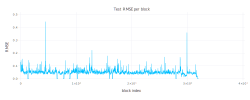

In [19]:
set_default_plot_size(25cm, 10cm)
sseTest35r_binned = data_bin(sseTest35r, 10)
plot(
    x=1:length(sseTest35r_binned),
y=[sqrt(v / 1000000) for v in sseTest35r_binned[1:end]],
    Geom.line,
    Guide.title("Test RMSE per block"),
    Guide.xlabel("block index"),
    Guide.ylabel("RMSE")
)

In [8]:
using Distributions
using GZip

In [9]:
#feature = ones(201) # this can be replaced by a fancy learned feature
function write_sam_file(outFile, controlFiles, features, beta, genomeLength=3250000000; scaleFactor=1.0)
    
    # build our control feature maps
    readers = [FeatureMap(BamReader(controlFiles[i], false, ReferenceContigs_hg38), features[i]) for i in 1:length(controlFiles)]

    # build our writer
    sw = SamWriter(outFile, ReferenceContigs_hg38)
    
    
    # we want to compute XtX and Xty block by block
    P = length(controlFiles) + 1
    blockSize = 100000
    genomeLength = sum(ReferenceContigs_hg38.sizes)

    # use denseblocks to iterate over blocks of the target and control data
    count = 0
    pos = 1
    for block in denseblocks(readers, blockSize, constantColumn=true)
        
        pred = block*beta
        
        for i in 1:blockSize
            outputRead = rand(Bernoulli(min(max(pred[i]*scaleFactor, 0.0), 1)))
            if outputRead == 1
                #println("$pos $(pred[i])")
                writeRead(sw, pos, 0, LENGTH=30)
            end
            pos += 1
            if pos > genomeLength break end
        end
        
        if pos > genomeLength break end
        count += 1

        # break early because this is just an example
#         if count > 1000
#             break
#         end

        if count % 100 == 0
            println(pos)
        end
    end
end

write_sam_file (generic function with 2 methods)

In [ ]:
f = GZip.open("$root/ENCFF000NYK_pred35r_w50.sam.gz", "w")
write_sam_file(f, ["$root/$id.bam" for id in controlIds35], features35, betas35r; scaleFactor=4)
GZip.close(f)

In [16]:
export SamWriter, writeHeader, writeRead

#=
USAGE:
sw = SamWriter(STDOUT, ReferenceContigs_hg38)
writeRead(sw, 100, 16)
writeRead(sw, 500000000, 16)
=#

type Sam_Writer
    #a output stream object to write to
    Outstream
    contigs::ReferenceContigs
    cur_ref::Int64
end

#constructor for sam_Writer. 
#Automatically writes the header as it is instantiated
function SamWriter(output_stream, contigs)
    sw = Sam_Writer(output_stream, contigs, 1)
    writeHeader(sw)
    sw
end

function writeHeader(sw::Sam_Writer)
    write(sw.Outstream, "@HD\tVN:1.0\tSO:coordinate\n")
    for j in 1:sw.contigs.count
        name = sw.contigs.names[j]
        size = sw.contigs.sizes[j]
        write(sw.Outstream, "@SQ\tSN:$(name)\tLN:$(size)\n")
    end
    write(sw.Outstream, "@PG\tID:PureSeq\tPN:PureSeq\n")
end

function writeRead(sw::Sam_Writer, POS::Int64, FLAG::Int64; MAPQ::Int64=15, LENGTH::Int64=0)

    #Figure out the ref_name
    while POS > sw.contigs.offsets[sw.cur_ref]+sw.contigs.sizes[sw.cur_ref]
        sw.cur_ref += 1
    end
    
    #What we are writing out
    QNAME = "PureSeq"
    FLAG = FLAG
    RNAME = sw.contigs.names[sw.cur_ref]
    POS = POS-sw.contigs.offsets[sw.cur_ref]
    if POS < 0
        write(STDERR, "ERROR: reads need to be fed in order")
        return -1 
    end
    
    MAPQ = MAPQ
    if LENGTH == 0
        CIGAR = "*"
    else
        CIGAR = "$(LENGTH)M"
    end
    RNEXT = "*"
    PNEXT = 0
    TLEN = 0
    SEQ = "*"
    QUAL = "*"
    
    output = "$(QNAME)\t$(FLAG)\t$(RNAME)\t$(POS)\t$(MAPQ)\t$(CIGAR)\t$(RNEXT)\t$(PNEXT)\t$(TLEN)\t$(SEQ)\t$(QUAL)\n"
    write(sw.Outstream, output)
end


writeRead (generic function with 1 method)